In [1]:
from collections import defaultdict, deque
import datetime
import math
import time
import torch
import torch.distributed as dist

import errno
import os


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


class ConfusionMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, a, b):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=a.device)
        with torch.no_grad():
            k = (a >= 0) & (a < n)
            inds = n * a[k].to(torch.int64) + b[k]
            self.mat += torch.bincount(inds, minlength=n**2).reshape(n, n)

    def reset(self):
        self.mat.zero_()

    def compute(self):
        h = self.mat.float()
        acc_global = torch.diag(h).sum() / h.sum()
        acc = torch.diag(h) / h.sum(1)
        iu = torch.diag(h) / (h.sum(1) + h.sum(0) - torch.diag(h))
        return acc_global, acc, iu

    def reduce_from_all_processes(self):
        if not torch.distributed.is_available():
            return
        if not torch.distributed.is_initialized():
            return
        torch.distributed.barrier()
        torch.distributed.all_reduce(self.mat)

    def __str__(self):
        acc_global, acc, iu = self.compute()
        return (
            'global correct: {:.1f}\n'
            'average row correct: {}\n'
            'IoU: {}\n'
            'mean IoU: {:.1f}').format(
                acc_global.item() * 100,
                ['{:.1f}'.format(i) for i in (acc * 100).tolist()],
                ['{:.1f}'.format(i) for i in (iu * 100).tolist()],
                iu.mean().item() * 100)


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {}'.format(header, total_time_str))


def cat_list(images, fill_value=0):
    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    batch_shape = (len(images),) + max_size
    batched_imgs = images[0].new(*batch_shape).fill_(fill_value)
    for img, pad_img in zip(images, batched_imgs):
        pad_img[..., :img.shape[-2], :img.shape[-1]].copy_(img)
    return batched_imgs


def collate_fn(batch):
    images, targets = list(zip(*batch))
    batched_imgs = cat_list(images, fill_value=0)
    batched_targets = cat_list(targets, fill_value=255)
    return batched_imgs, batched_targets


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    elif hasattr(args, "rank"):
        pass
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    setup_for_distributed(args.rank == 0)

(2000, 128, 128, 3)


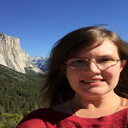

In [2]:
import numpy as np
from PIL import Image

imgs = np.load('data/gsn_img_uint8.npy')
print(imgs.shape)

Image.fromarray(imgs[0], 'RGB')

(128, 128, 3)


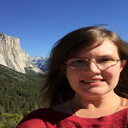

In [3]:
import random

should_flip_v = True if random.uniform(0, 1) > 1/2 else False
should_flip_h = True if random.uniform(0, 1) > 1/2 else False

img = imgs[0]
if should_flip_v:
    img = np.flip(img, axis=0)
if should_flip_h:
    img = np.flip(img, axis=1)
    
print(img.shape)
    
Image.fromarray(img, 'RGB')

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet86(nn.Module):
    def __init__(self, features=32):
        super(UNet86, self).__init__()
        
        self.conv1 = nn.Conv2d(3, features, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(features, features * 2, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(features * 2, features * 4, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(features * 4, features * 8, kernel_size=3, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm2d(num_features=features)
        self.bn2 = nn.BatchNorm2d(num_features=features * 2)
        self.bn3 = nn.BatchNorm2d(num_features=features * 4)
        self.bn4 = nn.BatchNorm2d(num_features=features * 8)
        
        self.bottleneck = nn.Conv2d(features * 8, features * 16, kernel_size=3, stride=2, padding=1)
        self.bottleneck_bn = nn.BatchNorm2d(num_features=features * 16)
        
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.dec4 = nn.Conv2d((features * 8) * 2, features * 8, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.dec3 = nn.Conv2d((features * 4) * 2, features * 4, kernel_size=3, padding=1)
        
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.dec2 = nn.Conv2d((features * 2) * 2, features * 2, kernel_size=3, padding=1)
        
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.dec1 = nn.Conv2d((features) * 2, features, kernel_size=3, padding=1)
        
        self.upconv = nn.ConvTranspose2d(features, features, kernel_size=2, stride=2)
        self.conv = nn.Conv2d(in_channels=features, out_channels=1, kernel_size=1)
        
        
    def forward(self, x):
        enc1 = self.bn1(F.relu(self.conv1(x)))
        enc2 = self.bn2(F.relu(self.conv2(enc1)))
        enc3 = self.bn3(F.relu(self.conv3(enc2)))
        enc4 = self.bn4(F.relu(self.conv4(enc3)))
        
        bottleneck = self.bottleneck_bn(F.relu(self.bottleneck(enc4)))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = self.bn4(self.dec4(torch.cat((dec4, enc4), dim=1)))
        dec3 = self.upconv3(dec4)
        dec3 = self.bn3(self.dec3(torch.cat((dec3, enc3), dim=1)))
        dec2 = self.upconv2(dec3)
        dec2 = self.bn2(self.dec2(torch.cat((dec2, enc2), dim=1)))
        dec1 = self.bn1(self.upconv1(dec2))
        dec1 = self.dec1(torch.cat((dec1, enc1), dim=1))
        
        return torch.sigmoid(self.conv(self.upconv(dec1)))
    

net86 = UNet86()

np_img = np.transpose(np.array(imgs[0]), (2, 0, 1))
print(np_img.shape)

np_imgs = np.array([np_img])

torch_imgs = torch.from_numpy(np_imgs)
z = net86.forward(torch_imgs.float())

print(z.shape)
print(z)


(3, 128, 128)
torch.Size([1, 1, 128, 128])
tensor([[[[0.5285, 0.4798, 0.5113,  ..., 0.4750, 0.4847, 0.4823],
          [0.4884, 0.4917, 0.5011,  ..., 0.4912, 0.4741, 0.4908],
          [0.4586, 0.4520, 0.4448,  ..., 0.4904, 0.4887, 0.5002],
          ...,
          [0.4726, 0.4846, 0.5374,  ..., 0.4846, 0.4985, 0.4890],
          [0.5122, 0.4740, 0.4729,  ..., 0.4872, 0.4910, 0.4896],
          [0.4755, 0.4976, 0.5534,  ..., 0.4760, 0.4944, 0.4915]]]],
       grad_fn=<SigmoidBackward>)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, features=32):
        super(UNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, features, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(features, features * 2, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(features * 2, features * 4, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(features * 4, features * 8, kernel_size=3, stride=2, padding=1)
        
        self.e1 = nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1)
        self.e2 = nn.Conv2d(features * 2, features * 2, kernel_size=3, stride=1, padding=1)
        self.e3 = nn.Conv2d(features * 4, features * 4, kernel_size=3, stride=1, padding=1)
        self.e4 = nn.Conv2d(features * 8, features * 8, kernel_size=3, stride=1, padding=1)
        
        self.bn1 = nn.BatchNorm2d(num_features=features)
        self.bn2 = nn.BatchNorm2d(num_features=features * 2)
        self.bn3 = nn.BatchNorm2d(num_features=features * 4)
        self.bn4 = nn.BatchNorm2d(num_features=features * 8)
        
        self.bottleneck = nn.Conv2d(features * 8, features * 16, kernel_size=3, stride=2, padding=1)
        self.bottleneck_bn = nn.BatchNorm2d(num_features=features * 16)
        
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.dec4 = nn.Conv2d((features * 8) * 2, features * 8, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.dec3 = nn.Conv2d((features * 4) * 2, features * 4, kernel_size=3, padding=1)
        
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.dec2 = nn.Conv2d((features * 2) * 2, features * 2, kernel_size=3, padding=1)
        
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.dec1 = nn.Conv2d((features) * 2, features, kernel_size=3, padding=1)
        
        self.d4 = nn.Conv2d(features * 8, features * 8, kernel_size=3, padding=1)
        self.d3 = nn.Conv2d(features * 4, features * 4, kernel_size=3, padding=1)
        self.d2 = nn.Conv2d(features * 2, features * 2, kernel_size=3, padding=1)
        self.d1 = nn.Conv2d(features, features, kernel_size=3, padding=1)
        
        self.upconv = nn.ConvTranspose2d(features, features, kernel_size=2, stride=2)
        self.conv = nn.Conv2d(in_channels=features, out_channels=1, kernel_size=1)
        
        
    def forward(self, x):
        enc1 = self.bn1(F.relu(self.e1(self.bn1(F.relu(self.conv1(x))))))
        enc2 = self.bn2(F.relu(self.e2(self.bn2(F.relu(self.conv2(enc1))))))
        enc3 = self.bn3(F.relu(self.e3(self.bn3(F.relu(self.conv3(enc2))))))
        enc4 = self.bn4(F.relu(self.e4(self.bn4(F.relu(self.conv4(enc3))))))
        
        bottleneck = self.bottleneck_bn(F.relu(self.bottleneck(enc4)))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = self.bn4(self.d4(F.relu(self.bn4(F.relu(self.dec4(torch.cat((dec4, enc4), dim=1)))))))
        dec3 = self.upconv3(dec4)
        dec3 = self.bn3(self.d3(F.relu(self.bn3(F.relu(self.dec3(torch.cat((dec3, enc3), dim=1)))))))
        dec2 = self.upconv2(dec3)
        dec2 = self.bn2(self.d2(F.relu(self.bn2(F.relu(self.dec2(torch.cat((dec2, enc2), dim=1)))))))
        dec1 = self.bn1(self.upconv1(dec2))
        dec1 = self.bn1(self.d1(F.relu(self.bn1(F.relu(self.dec1(torch.cat((dec1, enc1), dim=1)))))))
        
        return torch.sigmoid(self.conv(self.upconv(dec1)))
    

net = UNet()

np_img = np.transpose(np.array(imgs[0]), (2, 0, 1))
print(np_img.shape)

np_imgs = np.array([np_img])

torch_imgs = torch.from_numpy(np_imgs)
z = net.forward(torch_imgs.float())

print(z.shape)
print(z)


(3, 128, 128)
torch.Size([1, 1, 128, 128])
tensor([[[[0.4656, 0.5296, 0.6157,  ..., 0.5717, 0.5495, 0.5261],
          [0.5581, 0.4188, 0.5922,  ..., 0.5259, 0.5258, 0.4892],
          [0.5460, 0.6742, 0.6190,  ..., 0.5258, 0.5174, 0.5169],
          ...,
          [0.5256, 0.5223, 0.5086,  ..., 0.5220, 0.4853, 0.5018],
          [0.5274, 0.4893, 0.5289,  ..., 0.4505, 0.5268, 0.4927],
          [0.5395, 0.5141, 0.5406,  ..., 0.5179, 0.5394, 0.4915]]]],
       grad_fn=<SigmoidBackward>)


In [8]:
import torch
import random
import numpy as np

class TaskDatasetFlips(object):
    def __init__(self, imgs, masks):
#         self.imgs = imgs
#         self.masks = masks
        
        self.imgs = (list(map(lambda x: torch.from_numpy(np.transpose(np.array((x/255) - 1/2), (2, 0, 1))).float(), imgs)) +
            list(map(lambda x: torch.from_numpy(np.transpose(np.array((np.flip(x, axis=0)/255) - 1/2), (2, 0, 1))).float(), imgs)) +
            list(map(lambda x: torch.from_numpy(np.transpose(np.array((np.flip(x, axis=1)/255) - 1/2), (2, 0, 1))).float(), imgs)) +
            list(map(lambda x: torch.from_numpy(np.transpose(np.array((np.flip(np.flip(x, axis=0), axis=1)/255) - 1/2), (2, 0, 1))).float(), imgs)) +
            list(map(lambda x: torch.from_numpy(np.transpose(np.array((np.rot90(x)/255) - 1/2), (2, 0, 1))).float(), imgs)) +
            list(map(lambda x: torch.from_numpy(np.transpose(np.array((np.rot90(x, k=3)/255) - 1/2), (2, 0, 1))).float(), imgs))
                    )
        
        
        self.masks = (list(map(lambda x: torch.from_numpy(np.transpose(np.array((x/255)), (2, 0, 1))).float(), masks)) +
            list(map(lambda x: torch.from_numpy(np.transpose(np.array((np.flip(x, axis=0)/255)), (2, 0, 1))).float(), masks)) +
            list(map(lambda x: torch.from_numpy(np.transpose(np.array((np.flip(x, axis=1)/255)), (2, 0, 1))).float(), masks)) +
            list(map(lambda x: torch.from_numpy(np.transpose(np.array((np.flip(np.flip(x, axis=0), axis=1)/255)), (2, 0, 1))).float(), masks)) +
            list(map(lambda x: torch.from_numpy(np.transpose(np.array((np.rot90(x)/255)), (2, 0, 1))).float(), masks)) +
            list(map(lambda x: torch.from_numpy(np.transpose(np.array((np.rot90(x, k=3)/255)), (2, 0, 1))).float(), masks))
                      
                     )

#         print(f'len images {len(self.imgs)}')
        
    def __getitem__(self, idx):
        img = self.imgs[idx]
        mask = self.masks[idx]
        
#         should_flip_v = True if random.uniform(0, 1) > 1/2 else False
#         should_flip_h = True if random.uniform(0, 1) > 1/2 else False

#         if should_flip_v:
#             img, mask = np.flip(img, axis=0), np.flip(mask, axis=0)
#         if should_flip_h:
#             img,mask = np.flip(img, axis=1), np.flip(mask, axis=1)

#         print(img.shape)
    
        return img, mask
    
    def __len__(self):
        return len(self.imgs)
    
    
class TaskDataset(object):
    def __init__(self, imgs, masks):
#         self.imgs = imgs
#         self.masks = masks
        
        self.imgs = (list(map(lambda x: torch.from_numpy(np.transpose(np.array((x/255) - 1/2), (2, 0, 1))).float(), imgs)))
        
        self.masks = (list(map(lambda x: torch.from_numpy(np.transpose(np.array((x/255)), (2, 0, 1))).float(), masks)))

#         print(f'len images {len(self.imgs)}')
        
    def __getitem__(self, idx):
        img = self.imgs[idx]
        mask = self.masks[idx]
        
#         should_flip_v = True if random.uniform(0, 1) > 1/2 else False
#         should_flip_h = True if random.uniform(0, 1) > 1/2 else False

#         if should_flip_v:
#             img, mask = np.flip(img, axis=0), np.flip(mask, axis=0)
#         if should_flip_h:
#             img,mask = np.flip(img, axis=1), np.flip(mask, axis=1)

#         print(img.shape)
    
        return img, mask
    
    def __len__(self):
        return len(self.imgs)
    
dataset = TaskDatasetFlips(imgs=np.load('data/gsn_img_uint8.npy'), masks=np.load('data/gsn_msk_uint8.npy'))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

test_dataset = TaskDataset(imgs=np.load('data/test_gsn_image.npy'), masks=np.load('data/test_gsn_mask.npy'))
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
def train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value}'))
    header = 'Epoch: [{}]'.format(epoch)
    for image, target in metric_logger.log_every(data_loader, print_freq, header):
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])
        
#     lr_scheduler.step()

In [ ]:
model = UNet(features=64)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)

criterion = nn.BCELoss()

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

for epoch in range(15):
    train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, epoch, print_freq=500)
    
    correct_pixels = 0
    total_pixels = 0
    
    with torch.no_grad():
        i = 0
        for data in test_data_loader:
            i += 1
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            
            outputs_f1 = torch.flip( model(torch.flip(images, [2])), [2])
            outputs_f2 = torch.flip( model(torch.flip(images, [3])), [3])
            outputs_f12 = torch.flip( model(torch.flip(images, [2, 3])), [2, 3])
            
#             print(images.shape)
#             print(torch.rot90(images, 1, [2, 3]).shape)
            
            outputs_r90 = torch.rot90( model(torch.rot90(images, 1, [2, 3])), -1, [2, 3])
            outputs_r270 = torch.rot90( model(torch.rot90(images, 3, [2, 3])), -3, [2, 3])
            
            total_pixels += outputs.shape[0] * outputs.shape[1] * outputs.shape[2] * outputs.shape[3]
#             print(total_pixels, outputs.shape[0], outputs.shape[1], outputs.shape[2], outputs.shape[3])
            predicted = ((outputs + outputs_f1 + outputs_f2 + outputs_f12 + outputs_r90 + outputs_r270) / 6 > 0.5).float()
    
#             print(predicted)
#             print(outputs.shape)
#             print(labels.shape)
            correct_pixels += (predicted == labels).sum().item()
            
#             print(outputs.shape)
#             print(labels.shape)
#             print(outputs[0])
#             print(outputs[0].shape)

        print(f"items: {i}")
        print(f"Accuracy: {correct_pixels/total_pixels}")
        print(f"Correct items: {correct_pixels}/{total_pixels}")

Epoch: [0]  [   0/6000]  eta: 0:01:44  lr: 0.001  loss: 0.6810 (0.6810)  time: 0.0173  data: 0.0008  max mem: 503
Epoch: [0]  [ 500/6000]  eta: 0:01:35  lr: 0.001  loss: 0.4853 (0.5477)  time: 0.0172  data: 0.0004  max mem: 626
Epoch: [0]  [1000/6000]  eta: 0:01:26  lr: 0.001  loss: 0.4720 (0.5139)  time: 0.0171  data: 0.0003  max mem: 626
Epoch: [0]  [1500/6000]  eta: 0:01:17  lr: 0.001  loss: 0.3833 (0.4897)  time: 0.0173  data: 0.0004  max mem: 626
Epoch: [0]  [2000/6000]  eta: 0:01:08  lr: 0.001  loss: 0.4913 (0.4778)  time: 0.0172  data: 0.0003  max mem: 626
Epoch: [0]  [2500/6000]  eta: 0:01:00  lr: 0.001  loss: 0.3708 (0.4690)  time: 0.0172  data: 0.0003  max mem: 626
Epoch: [0]  [3000/6000]  eta: 0:00:51  lr: 0.001  loss: 0.4004 (0.4616)  time: 0.0172  data: 0.0003  max mem: 626
Epoch: [0]  [3500/6000]  eta: 0:00:43  lr: 0.001  loss: 0.3941 (0.4532)  time: 0.0173  data: 0.0004  max mem: 626
Epoch: [0]  [4000/6000]  eta: 0:00:34  lr: 0.001  loss: 0.3554 (0.4464)  time: 0.0181  d

In [ ]:
test_img = np.load('data/test_gsn_image.npy')[0]
test_mask = np.load('data/test_gsn_mask.npy')[0]

from PIL import Image

print(test_img.shape)
print(test_mask.shape)
Image.fromarray(test_img, 'RGB')
#Image.fromarray(np.resize(test_mask, (128, 128, 3)), 'RGB')

# print(test_img)
# print(test_mask)

print(len(np.load('data/test_gsn_image.npy')))

In [ ]:

def average_prediction(model, outputs, transforms, inverse_transforms):
    for output in outputs:
        for transform
    

In [ ]:
x = torch.arange(9).view(3, 3)
x

In [ ]:
torch.flip(x, (0,))

In [ ]:
torch.flip(x, (1,))

In [ ]:
torch.flip(torch.flip(x, (1,)), (1,))

In [ ]:
print(torch.flip(x, [0,1]))
print(torch.flip(torch.flip(x, [0,1]), [0, 1]))

In [ ]:
z = torch.rot90(x, 1, [0, 1])
print(z)
print(torch.rot90(z, -1, [0, 1]))

In [ ]:
x = torch.arange(18).view(2, 3, 3)
x

In [ ]:
torch.rot90(x, 1, [1, 2])